1. Indicate the imported packages/libraries


In [ ]:
import torch # library for building and training deep learning models.
torch.manual_seed(25) # Setting a random seed for reproducing the dataset
import torchvision # package containing popular datasets, model architectures, and image transformations.
import matplotlib.pyplot as plt # library for creating visualizations
import numpy as np # library for working with arrays and matrice
from torch import nn, optim, cuda # neural network module for defining neural networks and layers
import torch.nn.functional as F # functional module for defining activation functions and loss functions.
from torch.utils.data import DataLoader # module for efficiently loading data in batches during training
from torchvision import datasets, transforms # module for performing image transformations.
from torch.optim.lr_scheduler import StepLR, ExponentialLR # learning rate scheduling classes for adjusting the learning rate during training. steplR and ExponentialLr are one of these schedulers
from torch.utils.data import DataLoader # learning rate scheduling classes for adjusting the learning rate during training.
import time # library for working with time and timing code.
from sklearn.metrics import confusion_matrix, classification_report  # Functions from Scikit-learn for evaluating the performance of a classifier.
import seaborn as sns # ibrary for creating visualizations, in this case, for visualizing confusion matrices.

Using GPU if available

In [ ]:
# choose the device cuda else cpu
device = "cuda" if cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


2.Load the dataset 


In [ ]:
# Transformation of the data & Rotation
transform=transforms.Compose([
                    lambda img: transforms.functional.rotate(img, -90),
                    lambda img: transforms.functional.hflip(img),
                    transforms.ToTensor()
                ])

# Loading dataset
trainset = datasets.EMNIST(root='./data/EMNIST/', split='balanced', train=True, transform=transform, download=True) # segregate the train dataset from emnist 
testset = datasets.EMNIST(root='./data/EMNIST/', split='balanced', train=False, transform=transform, download=True)# segregate the test dataset from emnist 


3. Split data into a training dataset and a testing dataset using DataLoader in PyTorch


In [ ]:
batch_size= 64

# Dataloader for entire dataset
entireTrainset = torch.utils.data.DataLoader(trainset, shuffle=True)

# Calculate the size of the training and validation sets
trainSplit = int(0.8 * len(entireTrainset))  # 80% is used for training
valSplit = len(entireTrainset) - trainSplit  # 20% is used for validation
X_train, X_val = torch.utils.data.random_split(trainset, [trainSplit, valSplit])

# Dataloader
train_dl = DataLoader(X_train, batch_size=batch_size, shuffle=True)
validation_dl = DataLoader(X_val, batch_size=batch_size, shuffle=False) # segregate the validation dataset from the training dataset
test_dl = DataLoader(testset, batch_size=batch_size, shuffle=False)

4. Understand the dataset and visualize the dataset

*  Print out the number of training/testing samples in the dataset.

* Plot some figures to visualize some samples in the dataset


Classes:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
Number of classes:  47


Training and validation dataset information:
Number of entire training samples: 112800
Train data size: torch.Size([112800, 28, 28])
Train set size: 90240, Validation set size: 22560


Testing dataset information:
Number of testing samples: 18800
Test data size: torch.Size([18800, 28, 28])
Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


Figures with label mapping


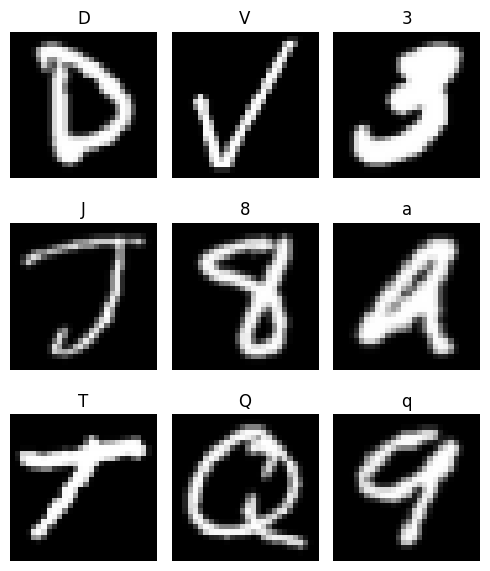



Figures without label mapping


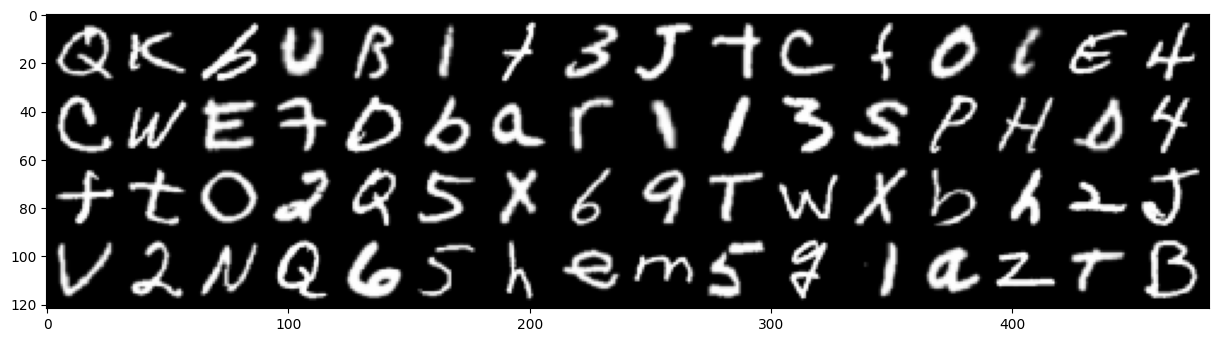

In [ ]:
# Printing information about classes 
classes = trainset.classes 
print('Classes: ', classes)
print('Number of classes: ', str(len(classes)))

# Printing training/validation information
print('\n')
print('Training and validation dataset information:')

# Printing length of entire training set
print(f'Number of entire training samples: {len(trainset)}')
print('Train data size:', trainset.data.shape)

# Printing train and val size after 80:20 split
print(f'Train set size: {trainSplit}, Validation set size: {valSplit}')

# Printing testing set information
print('\n')
print('Testing dataset information:')
print(f'Number of testing samples: {len(testset)}')
print('Test data size:', testset.data.shape)

# iterate the train data with samples
train_images, train_labels = next(iter(train_dl))
print(f'Feature batch shape: {train_images.shape}')
print(f'Labels batch shape: {train_labels.shape}')

# Printing samples of data

print('\n')

# With label mapping
print('Figures with label mapping')
mapping_label = {}
for item, label in enumerate(classes):
  mapping_label[item] = label
figure = plt.figure(figsize=(5, 6))
cols, rows = 3, 3
for i in range(1, (cols * rows) + 1):
    #select a random object from the training data
    samples = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[samples] # split the samples in image and labels
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray") #add the image as a subplot
    plt.title(mapping_label[label]) #title the image with its label
    plt.axis("off")
plt.tight_layout()
plt.show() # show the graph

# Without label mapping
print('\n')
print('Figures without label mapping')

# Visualzing a batch of 64 training samples
grid = torchvision.utils.make_grid(train_images,nrow=16)
plt.figure(figsize=(15,15)) # set the figiure size/dimensions
plt.imshow(np.transpose(grid,(1,2,0)),cmap='gray')







5. For the two models - MLP and CNNs:

 I. Hyperparameter tuning.

 II. After you obtain the best version of the model:

*   Plot the loss function graph with respect to the iteration/epoch

*   Plot the accuracy graph with respect to the iteration/epoch

*   Use either CPU or GPU to train your model, and print the training time


MLP

In [ ]:
# MLP (Multi Layer Perceptron)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2, batchNorm= True):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten() # flatten the output and save it to the flatten variable of the current instance
        self.hidden_layers = nn.Sequential( # create sequential hidden layers for MLP
            nn.Linear(input_size, hidden_size), # set first linear Layer
            nn.ReLU(), # set activation as relu
            nn.Dropout(p=dropout), # set dropout
            nn.BatchNorm1d(hidden_size) if batchNorm else nn.Identity(), # check is batchNorm is enabled
            nn.Linear(hidden_size, hidden_size), # set second hidden layer
            nn.ReLU(), # set activation to relu
            nn.Dropout(p=dropout), # set dropout 
            nn.BatchNorm1d(hidden_size) if batchNorm else nn.Identity(), # check is batchNorm is enabled
            nn.Linear(hidden_size, hidden_size), # set third hidden layer
            nn.ReLU(), # set activation function
            nn.Dropout(p=dropout), # set dropout
            nn.BatchNorm1d(hidden_size) if batchNorm else nn.Identity(), # set batch normalisation
            nn.Linear(hidden_size, output_size) # set the output layer
        )


    def forward(self, x):
        x = self.flatten(x)
        hidden = self.hidden_layers(x) # get the hidden layers output
        logits = hidden 
        return logits # return the output
  
input_size = 28 * 28  # input images are of size 28x28
hidden_size = 512
output_size = len(trainset.classes)  # Number of classes in the dataset

mlp = MLP(input_size, hidden_size, output_size).to(device)
print(mlp)


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden_layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=512, out_features=47, bias=True)
  )
)


Epoch [1/10], Train Loss: 1.0701, Train Acc: 0.6687, Val Loss: 0.6720, Val Acc: 0.7782
Epoch [2/10], Train Loss: 0.7440, Train Acc: 0.7557, Val Loss: 0.6099, Val Acc: 0.8106
Epoch [3/10], Train Loss: 0.6598, Train Acc: 0.7802, Val Loss: 0.5197, Val Acc: 0.8220
Epoch [4/10], Train Loss: 0.6128, Train Acc: 0.7926, Val Loss: 0.4796, Val Acc: 0.8362
Epoch [5/10], Train Loss: 0.5770, Train Acc: 0.8030, Val Loss: 0.4881, Val Acc: 0.8266
Epoch [6/10], Train Loss: 0.4658, Train Acc: 0.8372, Val Loss: 0.4153, Val Acc: 0.8592
Epoch [7/10], Train Loss: 0.4326, Train Acc: 0.8471, Val Loss: 0.4237, Val Acc: 0.8629
Epoch [8/10], Train Loss: 0.4135, Train Acc: 0.8532, Val Loss: 0.3965, Val Acc: 0.8640
Epoch [9/10], Train Loss: 0.4020, Train Acc: 0.8553, Val Loss: 0.4006, Val Acc: 0.8643
Epoch [10/10], Train Loss: 0.3933, Train Acc: 0.8594, Val Loss: 0.3924, Val Acc: 0.8652
Training time: 232.42 seconds


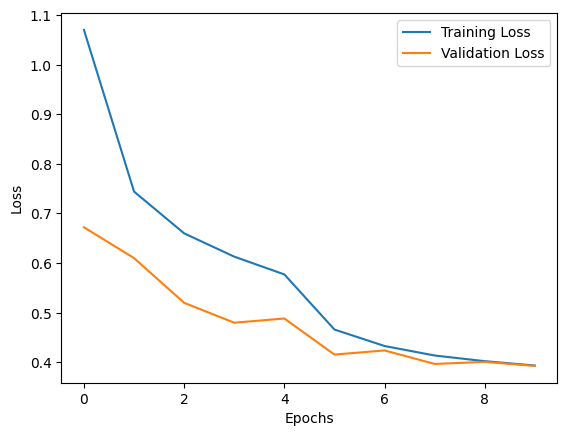

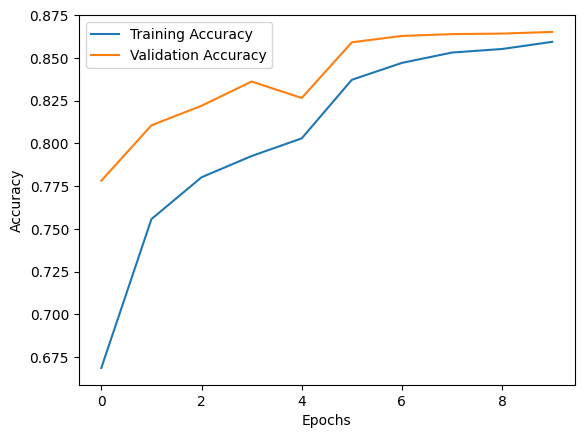

In [ ]:
# Train MLP model

# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(mlp.parameters(), lr=0.005)
# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
mlp.to(device)

num_epochs = 10  # Number of epochs for training
train_losses = []  # List to store training losses
val_losses = []  # List to store validation losses
train_acc = []  # List to store training accuracy
val_acc = []  # List to store validation accuracy

start_time = time.time()  # Start time for training


for epoch in range(num_epochs):
    # Training
    mlp.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss_t = running_loss / len(train_dl)
    epoch_acc_t = correct / total
    train_losses.append(epoch_loss_t)
    train_acc.append(epoch_acc_t)

    # Validation
    mlp.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_dl):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mlp(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss_v = running_loss / len(validation_dl)
    epoch_acc_v = correct / total
    val_losses.append(epoch_loss_v)
    val_acc.append(epoch_acc_v)


    # Update learning rate
    lr_scheduler.step()

        # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss_t:.4f}, Train Acc: {epoch_acc_t:.4f}, "
          f"Val Loss: {epoch_loss_v:.4f}, Val Acc: {epoch_acc_v:.4f}")

end_time = time.time()  # End time for training
print(f"Training time: {end_time - start_time:.2f} seconds")

# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



CNN

CNN(
  (convlayer1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (convlayer2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=47, bias=True)
  (l2): MSELoss()
  (firstBatch): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (secondBatch): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_function): ReLU()
)
Epoch [1/10], Train Loss: 0.727, Train Acc: 0.762, Val Loss: 0.514, Val Acc: 0.825
Epoch [2/10], Train Loss: 0.378, Train Acc: 0.865, Val Loss: 0.383, Val Acc: 0.866
Epoch [3/10], Train Loss: 0.344, Train Acc: 0.876, Val Loss: 0.370, Val Acc: 0.870
Epoch [4/10], Train Loss: 0.338, Train Acc: 0.878, Val Loss: 0.369, Val Acc: 0.870
Epoch [5/10], Train Loss: 0.338, Train Acc: 0.878, Val Loss: 0.369, Val Acc: 0.870
Epoch [6/10], Train Loss

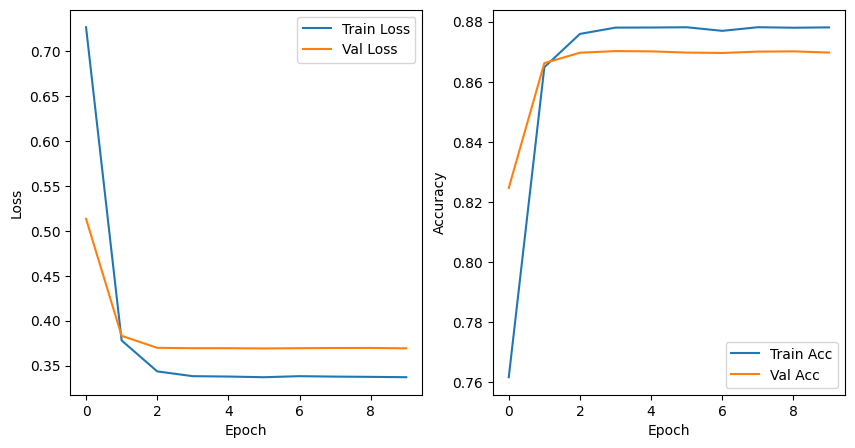

In [ ]:
# Train CNN model

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, batch_norm=True, dropout=True, activation='relu', l1_regularization=False, l2_regularization=False):
        super(CNN, self).__init__()
        self.convlayer1 = nn.Conv2d(1, 6, 5)
        self.convlayer2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 47) # 47 classes in EMNIST Balanced dataset
        self.batch_norm = batch_norm # set the batch_norm value to the current instance of batch_norm variable
        self.dropout = dropout # set the dropout value to the current instance of dropout variable 
        self.activation = activation # set the activation value to the current instance of activation variable
        self.l1_regularization = l1_regularization # set l1_regularisation value to the current instance
        self.l2_regularization = l2_regularization # set l2_regularisation value to the current instance
        if self.l1_regularization: # check if l1 regularisation is True
            self.l1 = nn.L1Loss() # set value for L1 regularisation
        if self.l2_regularization: # check if L2 regularisation is True
            self.l2 = nn.MSELoss() # set value for L2 regularisation
        if self.batch_norm: # check if batch normalisation is True 
            self.firstBatch = nn.BatchNorm2d(6) # set the firstbatch to 6
            self.secondBatch = nn.BatchNorm2d(16) # set the second batch to 16
        if self.dropout: # check if dropout is set to True
            self.firstDropout = nn.Dropout2d(p=0.2) # set first dropout to 0.25
            # self.secondDropout = nn.Dropout2d(p=0.5) # set second dropout to 0.5
        if self.activation == 'relu': # check if activation is relu
            self.activation_function = nn.ReLU() # set activation to relu
        elif self.activation == 'leaky_relu': # check if activation function is leaky_relu
            self.activation_function = nn.LeakyReLU(negative_slope=0.01) # set activation function to leaky_relu
        elif self.activation == 'elu': # check if activation function is elu 
            self.activation_function = nn.ELU() # set activation function to elu
      

    def forward(self, x):
        x = self.convlayer1(x) # set the first layer to x as input
        if self.batch_norm: # check the batch normalisation
            x = self.firstBatch(x) # set the first batch to x
        x = self.activation_function(x) # set first activation function value to x variable
        if self.dropout: # check the dropout value 
            x = self.firstDropout(x) # If dropout is true, set the x to firstDropout
        x = nn.functional.max_pool2d(x, 2) 
        x = self.convlayer2(x) # set second layer to x
        if self.batch_norm: # check batch normalisation
            x = self.secondBatch(x) # if true update the value by the value we get from the second batch function
        x = self.activation_function(x) # set the activation function to x
        # if self.dropout: # chech if dropout is True/False
            # x = self.secondDropout(x) # If True set second dropout value to x
        x = nn.functional.max_pool2d(x, 2) 
        x = x.view(-1, 16 * 4 * 4) # set a view to x
        x = self.fc1(x) # update x by the value of first function
        x = self.activation_function(x) # update x by first activation function
        x = self.fc2(x) # update x by second function
        x = self.activation_function(x) # update x by second activation function
        x = self.fc3(x) # update x by third function
        return x

# Initialize the CNN model
cnn = CNN(batch_norm=True, dropout=False, activation='relu', l1_regularization=False, l2_regularization=True)

# cnn = CNN(batch_norm=batch_norm, dropout=dropout, activation=activation, l1_regularization=l1_regularization, l2_regularization=l2_regularization)
print(cnn)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() # set criterion as crossEntropyLoss
optimizer = optim.Adam(cnn.parameters(), lr=0.005)
# for using Exponential learning rate scheduler uncomment the Exponential statement and comment the StepLr statement
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
# scheduler = ExponentialLR(optimizer, gamma=0.1)

# Train the CNN model
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn.to(device)

num_epochs = 10  # Number of epochs for training
train_losses = []  # List to store training losses
val_losses = []  # List to store validation losses
train_acc = []  # List to store training accuracy
val_acc = []  # List to store validation accuracy

start_time = time.time()  # Start time for training

for epoch in range(num_epochs):
    # Training
    cnn.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss_t = running_loss / len(train_dl)
    epoch_acc_t = correct / total
    train_losses.append(epoch_loss_t)
    train_acc.append(epoch_acc_t)

    # Validation
    cnn.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_dl):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss_v = running_loss / len(validation_dl)
    epoch_acc_v = correct / total
    val_losses.append(epoch_loss_v)
    val_acc.append(epoch_acc_v)

    # Update learning rate
    scheduler.step()

    # Print the training and validation loss and accuracy for each epoch
    print('Epoch [{}/{}], Train Loss: {:.3f}, Train Acc: {:.3f}, Val Loss: {:.3f}, Val Acc: {:.3f}'
          .format(epoch + 1, num_epochs, train_losses[-1], train_acc[-1], val_losses[-1], val_acc[-1]))

end_time = time.time()  # End time for training
print(f"Training time: {end_time - start_time:.2f} seconds")

# Plot the training and validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


6. Testing both models

In [ ]:
def test(model):
    model.eval()
    running_loss = 0.0
    correct = 0
    predicted_labels = []
    true_labels = []
    total = 0
    print(f"Performance of {type(model).__name__} on testing data")
    with torch.no_grad():
        for i, (inputs, labels) in zip(range(6), test_dl):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

        figure = plt.figure(figsize=(10, 10))
        print('Prediction of the top six samples:')

        for j, (inputs, labels) in enumerate(zip(inputs, predicted)):
          if j >=6:
            break

          inputs, labels = inputs.to(device), labels.to(device)
          figure.add_subplot(2, 4, j+1) 

          plt.title(f'Predicted: {mapping_label[predicted[j].item()]}\nTrue: {mapping_label[labels.item()]}')
          plt.axis("off")
          plt.imshow(inputs.squeeze().cpu().numpy(), cmap="gray")

    test_loss = running_loss / len(test_dl)
    test_acc = 100 * correct / total

    # Plot the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(len(classes))))
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Test Loss: {test_loss:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")

    # Print the classification report
    report = None
    report = classification_report(true_labels, predicted_labels, target_names=classes, digits=3, output_dict=True)

    # Print the average metrics
    avg_precision = report["macro avg"]["precision"]
    avg_recall = report["macro avg"]["recall"]
    avg_f1 = report["macro avg"]["f1-score"]
    avg_accuracy = test_acc / 100  # Convert from percentage to decimal
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-score: {avg_f1:.3f}")
    print(f"Average Accuracy: {avg_accuracy:.3f}")
 



Performance of MLP on testing data
Prediction of the top six samples:


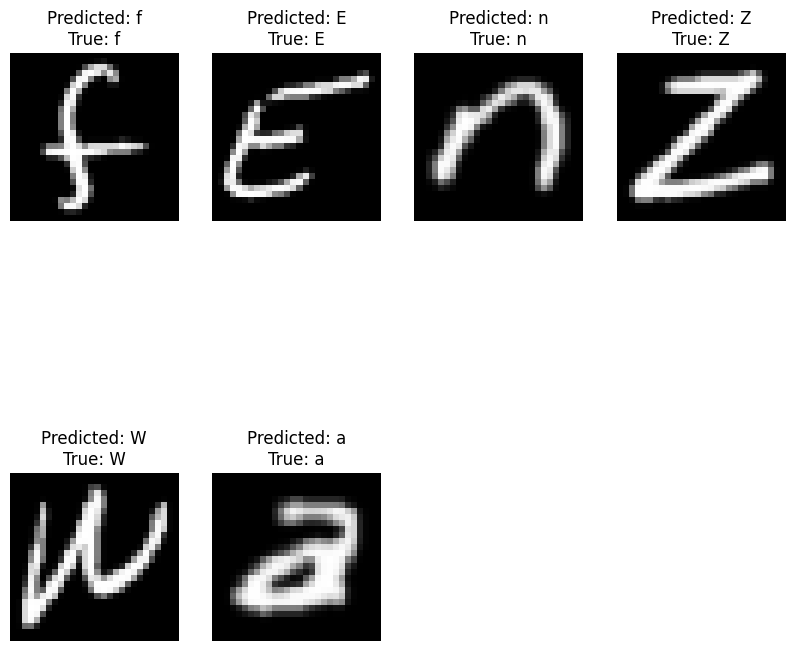

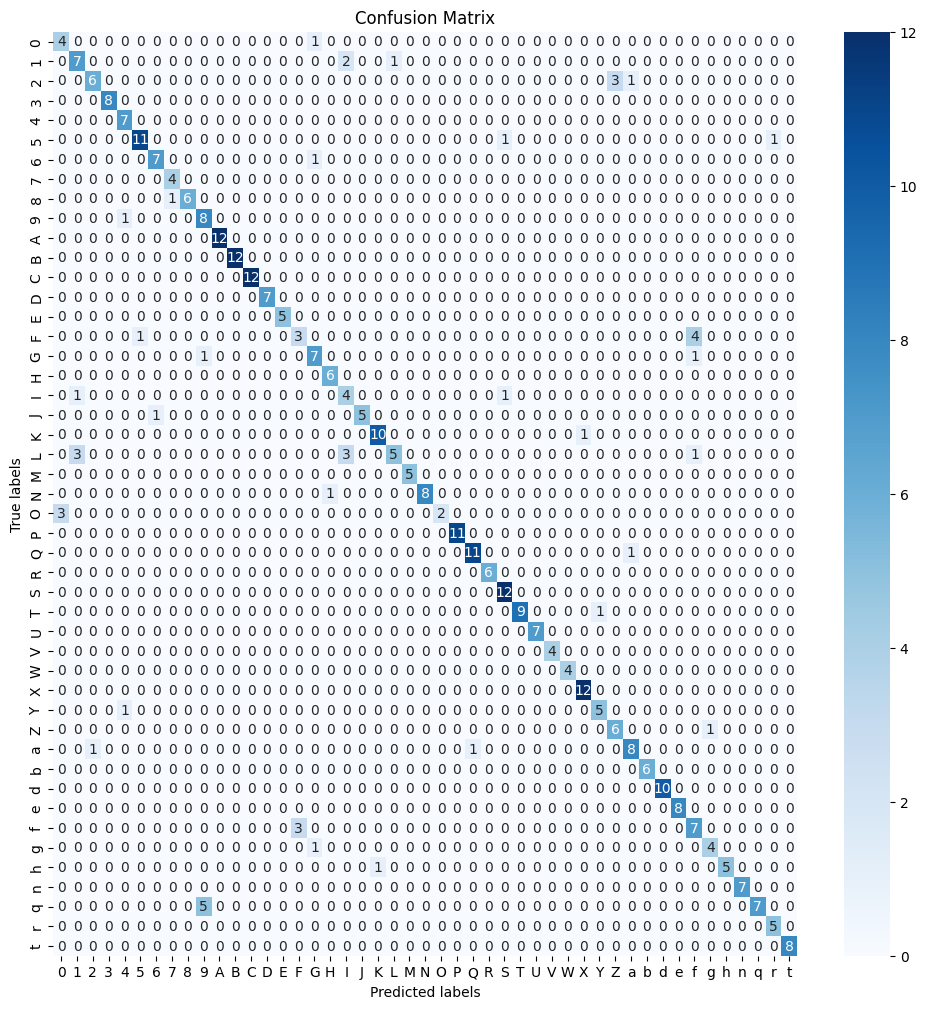

Test Loss: 0.008
Test Accuracy: 86.719
Average Precision: 0.881
Average Recall: 0.874
Average F1-score: 0.868
Average Accuracy: 0.867


In [ ]:
test(mlp)

Performance of CNN on testing data
Prediction of the top six samples:


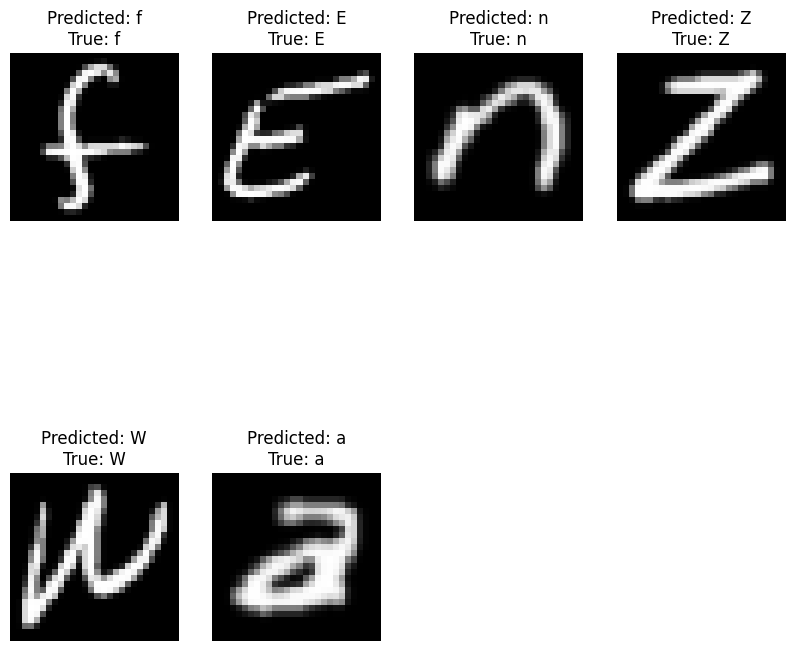

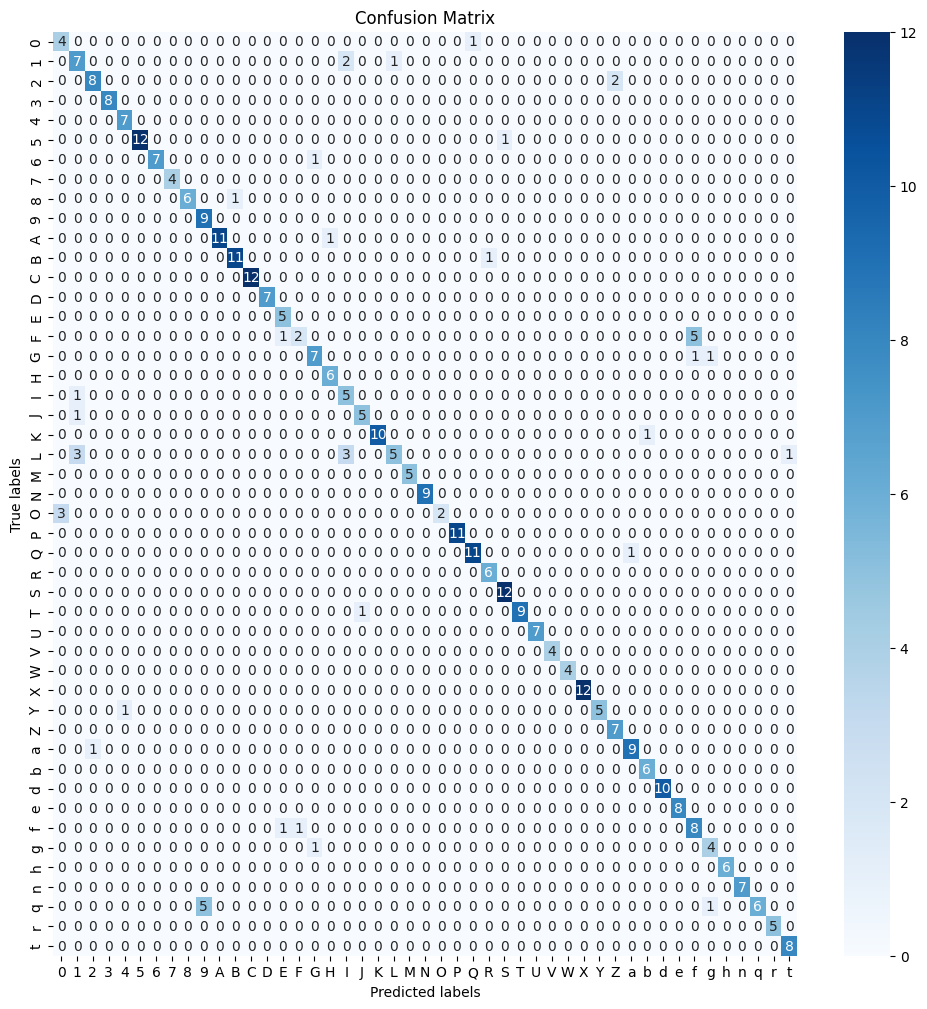

Test Loss: 0.008
Test Accuracy: 88.281
Average Precision: 0.894
Average Recall: 0.891
Average F1-score: 0.880
Average Accuracy: 0.883


In [ ]:
test(cnn)